In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import math
import os
import os.path as osp
import shutil

import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from tqdm.notebook import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Let's define some utilities for working with dirs:

In [3]:
def force_makedir(dir):
    if osp.isdir(dir):
       shutil.rmtree(dir)
    os.makedirs(dir)

...and image i/o:

In [4]:
from collections import namedtuple
import yaml

Camera = namedtuple('Camera', ['height', 'width', 'intrinsic_matrix'])

def load_rgb(fpath):
    return np.asarray(cv2.imread(fpath, cv2.COLOR_BGR2RGB))


def load_depth(fpath, min_depth=10., max_depth=1000):
    depth = np.asarray(cv2.imread(fpath, cv2.IMREAD_UNCHANGED), dtype=np.float32)
    depth[depth < min_depth] = 0
    depth[depth > max_depth] = max_depth
    return depth


def load_camera_params(fpath):
    with open(fpath, 'r') as file:
        camera_cfg = yaml.safe_load(file)

    height = camera_cfg['height']
    width = camera_cfg['width']
    intrinsic_matrix = np.array(camera_cfg['K']).reshape(3, 3)
    return Camera(height=height, width=width, intrinsic_matrix=intrinsic_matrix)


def save_rgb(rgb, fpath):
    return cv2.imwrite(fpath, rgb)


def save_depth(depth, fpath):
    return cv2.imwrite(fpath, depth, cv2.IMREAD_UNCHANGED)


def show_image(image, title=None):
    fig = plt.figure()
    if title is not None:
        plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    fig.show()


def show_frame(frame):
    fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
    fig.suptitle(f'Frame {frame.fid}')
    ax[0].set_title(f'RGB')
    ax[0].imshow(frame.rgb)
    ax[0].axis('off')
    ax[1].set_title(f'Depth')
    ax[1].imshow(frame.depth)
    ax[1].axis('off')
    plt.tight_layout()
    fig.show()

For convenience, let's create a class for a dataset and for a single frame:

In [5]:
class Frame:

    def __init__(self, fid, rgb, depth, camera_params):
        self.fid = fid

        if isinstance(rgb, np.ndarray) and rgb.ndim==3 and rgb.shape[2]==3:
            self.rgb = rgb
            self.rgb_fpath = None
        elif isinstance(rgb, str) and osp.isfile(rgb):
            self.rgb = load_rgb(rgb)
            self.rgb_fpath = rgb
        else:
            raise ValueError(f'failed to initialize Frame with rgb of type {type(rgb)}')

        if isinstance(depth, np.ndarray) and depth.ndim==2:
            self.depth = depth
            self.depth_fpath = None
        elif isinstance(depth, str) and osp.isfile(depth):
            self.depth = load_depth(depth)
            self.depth_fpath = depth
        else:
            raise ValueError(f'failed to initialize Frame with depth of type {type(depth)}')

        self.camera_params = camera_params
        self.height = self.camera_params.height
        self.width = self.camera_params.width

    def __repr__(self):
        return (
            f'Frame(id={self.fid}, rgb_fpath={self.rgb_fpath}, '
            f'depth={self.depth_fpath}, '
            f'height={self.height}, width={self.width})')


class Dataset:

    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.rgb_dir = osp.join(self.data_dir, 'rgb')
        self.depth_dir = osp.join(self.data_dir, 'depth')
        self.frame_ids = sorted([
            osp.splitext(f)[0].lstrip('color_')
            for f in os.listdir(self.rgb_dir)])

        camera_fpath = osp.join(self.data_dir, 'camera_params.yaml')
        self.camera_params = load_camera_params(camera_fpath)
        print(self.camera_params)

    def get_frame_by_id(self, frame_id):
        rgb_fname = f'color_{frame_id}.png'
        rgb_fpath = osp.join(self.rgb_dir, rgb_fname)
        rgb = load_rgb(rgb_fpath)

        depth_fname = f'aligned_depth_{frame_id}.png'
        depth_fpath = osp.join(self.depth_dir, depth_fname)
        depth = load_depth(depth_fpath)
        return Frame(
            fid=frame_id,
            rgb=rgb_fpath,
            depth=depth_fpath,
            camera_params=self.camera_params
        )

    def __getitem__(self, idx):
        frame_id = self.frame_ids[idx]
        return self.get_frame_by_id(frame_id)

    def __len__(self):
        return len(self.frame_ids)

Now we are ready to take a look at the data:

In [6]:
data_root = './pose_corrector_data/dataset'

In [7]:
data_dir = osp.join(data_root, 'inboard_rgbd')
dataset = Dataset(data_dir)

Camera(height=480, width=640, intrinsic_matrix=array([[606.59124756,   0.        , 319.14904785],
       [  0.        , 605.17895508, 241.69859314],
       [  0.        ,   0.        ,   1.        ]]))


Visualize the first 5 frames:

/tmp/ipykernel_1868241/2944422999.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


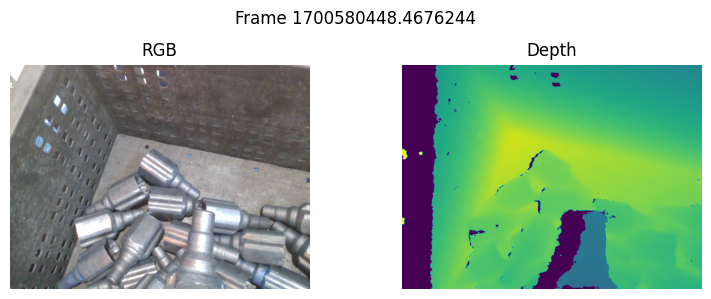

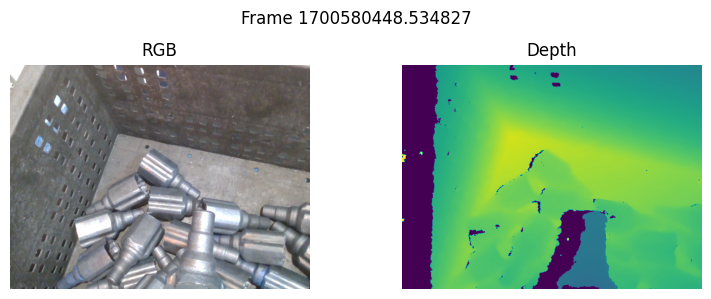

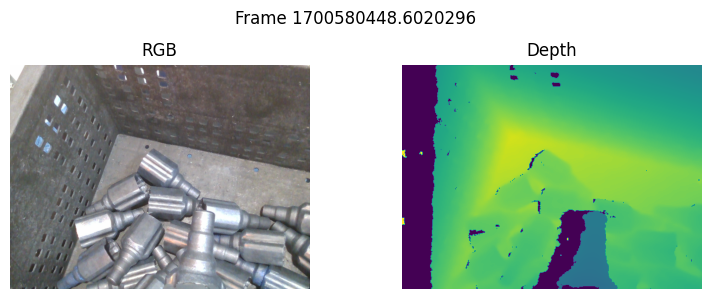

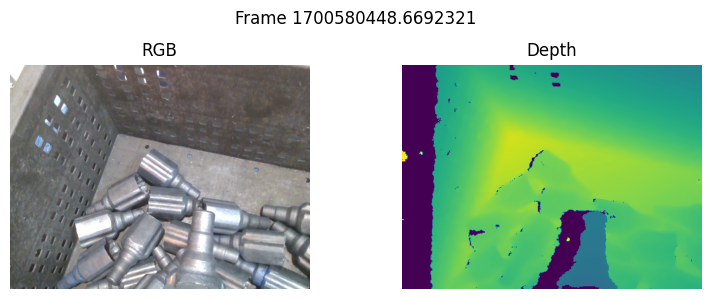

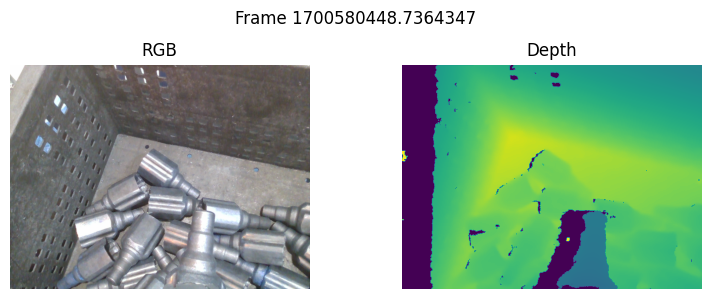

In [8]:
for idx in range(5):
    frame = dataset[idx]
    show_frame(frame)

# Task 1: Object Isolation

The goal of this task is to detect the `inboard` that is attached to the gripper, and to isolate it from other objects in the scene by creating a **mask**. The attached object could be found to be in various orientations on the magnetic gripper.

The following object is called `inboard`.

<img src="docs/imgs/inboard_2.png" alt="drawing" width="400"/>
<img src="docs/imgs/inboard_1.png" alt="drawing" width="200"/>


Bin picking scenario:

<img src="docs/imgs/binpick_background.png" alt="object in hand" width="400"/>

Camera view / Input data:

<img src="docs/imgs/Pose_Corrector_Challenge.drawio.png" alt="object in hand" width="400"/>

Instruction
---
Implement a method that is able to isolate the attached object from the surrounding pixels for the camera view RGB-D data provided. An example masked 'inboard' image: 

<img src="docs/imgs/object_mask.png" alt="object in hand" width="400"/>

For now, we can make two observations.

First, an inboard is closer to the camera, than other visible objects, so we can identify it by small depth values.

Second, depth maps are aligned with RGB images (ok, the depth filenames start with 'aligned_*' -- but it is always better to check). Accordingly, there are some gaps in depth maps due to an alignment, which are filled with zeros. 

So we cannot simply set a max depth threshold to find an inboard, but also need to ignore invalid zero values.

Let's prove it looking at a depth distribution:

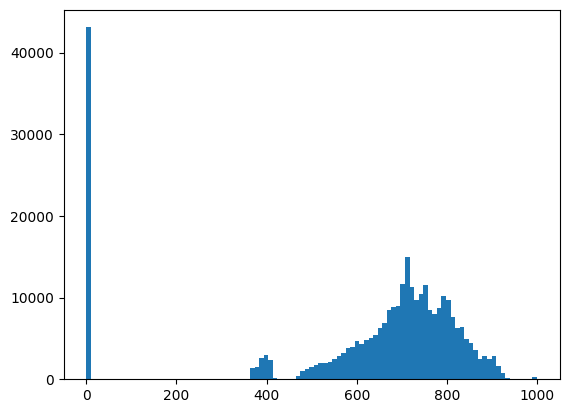

In [9]:
freqs, bins, _ = plt.hist(np.ravel(frame.depth), bins=np.linspace(0, 1000, 100))
plt.show()

The zeros are aplenty, as expected. Apart from that, this distribution is bimodal, and inboard depths are clearly distinguishable, localizing around 400-something. 

For a given image, we can set a threshold by 1) sorting all the depth values in ascending order and 2) finding the largest gap between two consecutive values, and selecting the first one.

Let's collect the statistics across the entire dataset, estimate a proper threshold for each frame, and take the maximum value of all the estimated thresholds (sometimes, other objects might appear in the vicinity of the camera, adding noise to the statistics -- that is why we consider a maximum value):

In [10]:
depth_thresholds = list()
for frame in tqdm(dataset, total=len(dataset)):
    depth = frame.depth
    mask = np.logical_and(depth > 400, depth < 500)
    if not mask.any():
        continue
    depth_values = sorted(depth[mask].ravel())
    diff = np.diff(depth_values)
    t = depth_values[np.argmax(diff)]
    depth_thresholds.append(t)

inboard_max_depth = max(depth_thresholds)
inboard_max_depth

  0%|          | 0/473 [00:00<?, ?it/s]

463.0

We also can roughly estimate a minimum threshold by selecting the first bin with a notable amount of values:

In [11]:
num_threshold = 1000
inboard_min_depth = bins[:-2][freqs[1:]>num_threshold].min()
inboard_min_depth

353.5353535353535

Now, we can segment an inboard by setting minimum and maximum depth thresholds. After this procedure, we might obtain a non-connected binary mask. To remove small noisy regions, we can find connected components in a binary mask, and filter out those of a small area:

In [12]:
def segment(frame):
    mask = np.logical_and(frame.depth>inboard_min_depth, frame.depth<inboard_max_depth)
    mask_g = mask2grayscale(mask)

    num_labels, label_idxs, stats, centroid = \
        cv2.connectedComponentsWithStats(mask_g, 4, cv2.CV_32S)
    for lidx in range(1, num_labels): 
        area = stats[lidx, cv2.CC_STAT_AREA]
        if area < 1000:
            mask[label_idxs==lidx] = 0

    return mask

Define mask utilities for conversion and visualization...

In [13]:
def mask2rgb(mask):
    mask3 = np.broadcast_to(mask[..., None], mask.shape + (3,))
    return np.uint8(mask3.astype(np.float32) * 255)


def mask2grayscale(mask):
    return np.uint8(mask.astype(np.float32) * 255)


def show_frame_with_mask(frame, mask, show=False, path_to_save=None):
    mask1 = mask[..., None]
    mask3 = np.broadcast_to(mask1, mask.shape + (3,))

    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10, 5))
    fig.suptitle(f'Frame {frame.fid}')
    
    ax[0, 0].set_title('RGB')
    ax[0, 0].imshow(frame.rgb)
    ax[0, 0].axis('off')
    
    ax[0, 1].set_title('Depth')
    ax[0, 1].imshow(frame.depth)
    ax[0, 1].axis('off')
    
    ax[0, 2].set_title('Mask')
    ax[0, 2].imshow(mask2rgb(mask))
    ax[0, 2].axis('off')
    
    ax[1, 0].set_title('Masked RGB')
    ax[1, 0].imshow(np.where(mask3, (0, 255, 0), frame.rgb))
    ax[1, 0].axis('off')

    ax[1, 1].set_title('Selected RGB')
    ax[1, 1].imshow(np.where(mask3, frame.rgb, 0))
    ax[1, 1].axis('off')

    ax[1, 2].set_title('Selected depth')
    ax[1, 2].imshow(np.where(mask, frame.depth, np.nan))
    ax[1, 2].axis('off')
    plt.tight_layout()
    
    if path_to_save is not None:
        fig.savefig(path_to_save)

    if show:
        fig.show()
    else:
        del fig
        plt.close()

...and give it a try:

/tmp/ipykernel_1868241/2731491716.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


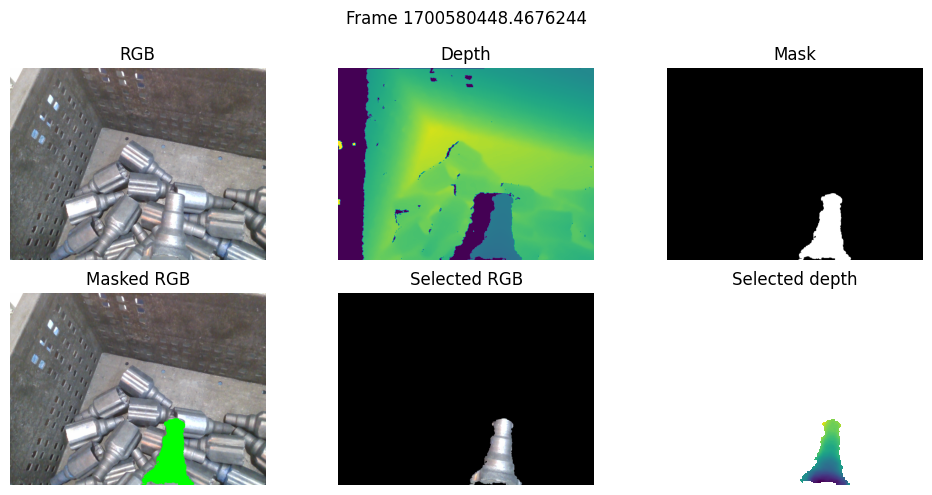

In [14]:
frame = dataset[0]
mask = segment(frame)
show_frame_with_mask(frame, mask, show=True)

Save the visualizations and masks:

In [15]:
output_dir = 'out1'
force_makedir(output_dir)

masks_dir = osp.join(output_dir, 'masks')
vis_dir = osp.join(output_dir, 'vis')
for dir in (masks_dir, vis_dir):
    force_makedir(dir)

for frame in tqdm(dataset):
    mask = segment(frame)
    save_rgb(mask2rgb(mask), osp.join(masks_dir, f'mask_{frame.fid}.png'))
    show_frame_with_mask(
        frame,
        mask,
        show=False,
        path_to_save=osp.join(vis_dir, f'vis_{frame.fid}.png'))

  0%|          | 0/473 [00:00<?, ?it/s]

## Task 2: Object Orientation

The goal of this task is check if the attached inboard is upright enough (good) or too slanted (bad).

If the **rotation** of the **object** attached to the robot gripper is **less than a threshold** (e.g: 60 degrees) in any direction from the **vertical axis**, then the **orientation** is **good**, **otherwise** the **orientation** is **bad**. 

![angle](docs/imgs/rotation_limit_inboard.png)

![angle](docs/imgs/pose_corrector_angle.png)


Instruction
---
Implement a method to sort the good and bad states from the provided RGB-D data by saving the images in two different folders according to their state. Examples:

**Good**: Object is upright enough, i.e. less than 60° rotated

![good_rotation](docs/imgs/g_2033.png)

**Bad**: Object is too slanted, i.e. more than 60° rotated

![bad_rotation](docs/imgs/pose_corrector_ch_extr_rot.png)

An inboard is of an elongated shape, so we can find the largest axis defining is orientation. This can be performed by applying PCA decomposition to mask coordinates (alternatively, to mask contours -- as they mostly coincide with an inboard orientation). The eigenvector corresponding to the largest eigenvalue is assumed to represent the dominating direction.

In [16]:
def PCA(pts):
    # Perform PCA analysis
    mean = np.empty((0))
    mean, eigvecs, eigvals = cv2.PCACompute2(pts, mean)
    eigvals = [v[0] for v in eigvals]
    center = mean[0].astype(int)
    return center, eigvecs, eigvals


def estimate_angle(mask, from_contours=False):
    mask_g = mask2grayscale(mask)

    if from_contours:
        contours, _ = cv2.findContours(mask_g, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        contour = max(contours, key=len)
        pts = np.float64([pt[0] for pt in contour])
    else:
        ys, xs = np.where(mask)
        pts = np.float64(np.stack([xs, ys]).T)
        contour = pts.reshape(-1, 1, 2).astype(int)
        
    center, eigvecs, eigvals = PCA(pts)

    angle = math.atan2(eigvecs[0,1], eigvecs[0,0])
    if angle < 0:
        angle = np.pi + angle
    
    angle = angle - np.pi / 2

    axis = eigvals[0] * eigvecs[0]
    return center, angle, axis

Let us check this in practice:

In [17]:
frame = dataset[0]
mask = segment(frame)
estimate_angle(mask, from_contours=True)

(array([397, 414]), 0.2523949805127048, array([-863.48789088, 3348.21987958]))

In [18]:
estimate_angle(mask, from_contours=False)

(array([401, 411]), 0.183840441045654, array([-410.00790064, 2205.05566065]))

The complete procedure includes checking whether an estimated angle lies within a given limit of 60 degrees:

In [19]:
def is_slanted(frame, angle_threshold=np.pi/3, show=False):
    mask = segment(frame)
    mask[450:] = 0
    center, angle, axis = estimate_angle(mask, False)

    if show:
        rgb = frame.rgb

        v = np.array([np.sin(angle), -np.cos(angle)])
        d = 0.02 * np.linalg.norm(axis) * v

        plt.title(f'Rotation: {np.rad2deg(angle):.1f} deg')
        plt.imshow(rgb)
        plt.plot([center[0]], [center[1]], color='limegreen', marker='o')
        plt.arrow(center[0], center[1], d[0], d[1], width=5, head_width=20, color='limegreen')
        plt.show()

    return np.abs(angle) > angle_threshold

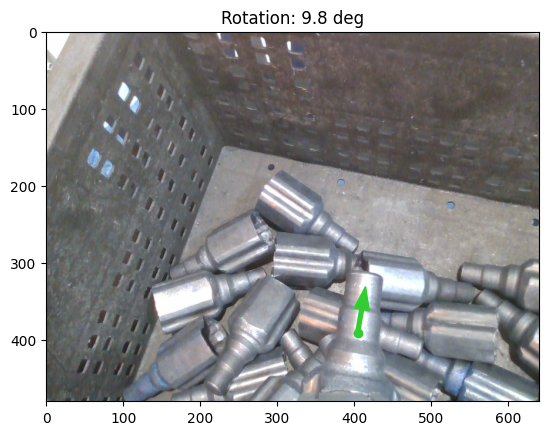

False

In [20]:
is_slanted(frame, show=True)

Estimate rotation for all samples in the dataset and save each sample to a folder according to the estimated angle:

In [21]:
output_dir = 'out2'
force_makedir(output_dir)

good_dir = osp.join(output_dir, 'good')
bad_dir = osp.join(output_dir, 'bad')
for dir in (good_dir, bad_dir):
    force_makedir(osp.join(dir, 'rgb'))
    force_makedir(osp.join(dir, 'depth'))

for frame in tqdm(dataset, total=len(dataset)):
    rgb_name = osp.basename(frame.rgb_fpath)
    depth_name = osp.basename(frame.depth_fpath)
    if is_slanted(frame):
        shutil.copyfile(frame.rgb_fpath, osp.join(bad_dir, 'rgb', rgb_name))
        shutil.copyfile(frame.depth_fpath, osp.join(bad_dir, 'depth', depth_name))
    else:
        shutil.copyfile(frame.rgb_fpath, osp.join(good_dir, 'rgb', rgb_name))
        shutil.copyfile(frame.depth_fpath, osp.join(good_dir, 'depth', depth_name))

  0%|          | 0/473 [00:00<?, ?it/s]

# Task 3: 6D Pose Estimation

The goal of this task is get the **6D Pose** of the `inboard` that is attached to the gripper, i.e:
- **Translation vector** in X, Y, Z directions.
- **Rotation Matrix**.

---
$$
\mathbf{H} = \begin{bmatrix}
r_{11} & r_{12} & r_{13} & t_x \\
r_{21} & r_{22} & r_{23} & t_y \\
r_{31} & r_{32} & r_{33} & t_z \\
0 & 0 & 0 & 1
\end{bmatrix}
$$
---

The image below shows the origin of the object as seen on the given mesh file:

![Pose 6D](docs/imgs/inboard_1.png)

Instruction
---
Implement a method that estimates the 6D pose of the attached object.

Please validate your method using the given RGD-D images or ROS bag file. It is further recommended to visualise the estimated pose overlayed on the input data for visual comparison.

> Tip: Use visualisation tools provided in RViz or Open3D to show your results 

Now we are ready to go 3D! 

We need to estimate a 3D orientation of an inboard. 

To this end, we can segment an inboard in an image, lift the inboard points into 3D using the corresponding depth image and camera parameters, and obtain a point cloud. 

Then, we can estimate the transformation (rotation+translation) that aligns this point cloud with a ground truth point cloud. The found transformation would actually define the desired orientation in a 3D space.

Let's start with creating a point cloud from an RGB-D image:

In [22]:
import open3d as o3d

def create_point_cloud(frame):
    intrinsics = o3d.camera.PinholeCameraIntrinsic(
        height=frame.height,
        width=frame.width,
        intrinsic_matrix=frame.camera_params.intrinsic_matrix)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color=o3d.geometry.Image(frame.rgb),
        depth=o3d.geometry.Image(frame.depth),
        depth_scale=1.0,
        depth_trunc=1000.0,
        convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        intrinsic=intrinsics,
        project_valid_depth_only=True)
    return pcd


def show_point_cloud_3d(pcd, title=''):
    pcd_copy = copy.deepcopy(pcd)
    pcd_copy.paint_uniform_color([0, 1, 0])
    return o3d.visualization.draw_geometries(
        [pcd_copy],
        window_name=title,
        height=480,
        width=640,
        zoom=1.,
        front=[0, 1, 0],
        lookat=[0, 0, 10],
        up=[0, 0, 1])


def draw_point_cloud_2d(pcd, title, extrinsic=np.eye(4), path_to_save=None):
    pcd_copy = copy.deepcopy(pcd)
    pcd_copy.paint_uniform_color([0, 1, 0])

    visualizer = o3d.visualization.Visualizer()
    visualizer.create_window(visible=False, height=512, width=512)
    visualizer.add_geometry(pcd_copy)

    ctr = visualizer.get_view_control()
    camera_params = ctr.convert_to_pinhole_camera_parameters()
    camera_params.intrinsic = o3d.camera.PinholeCameraIntrinsic(
        height=frame.height,
        width=frame.width,
        intrinsic_matrix=frame.camera_params.intrinsic_matrix)
    camera_params.extrinsic = extrinsic
    ctr.convert_from_pinhole_camera_parameters(camera_params, allow_arbitrary=True)
    visualizer.update_renderer()
    visualizer.poll_events()

    screenshot = np.uint8(np.asarray(visualizer.capture_screen_float_buffer(True)) * 255)
    show_image(screenshot, title=title)
    if path_to_save is not None:
        save_rgb(screenshot, fpath=path_to_save)

To create a point cloud of an inboard rather than of the entire scene, we should mask the depth map with an inboard mask:

In [23]:
def extract_inboard(frame):
    mask = segment(frame)
    frame.depth = np.where(mask, frame.depth, 0)
    pcd = create_point_cloud(frame)
    return pcd

Let's see how it works:

In [24]:
frame = dataset[0]
pcd = extract_inboard(frame)
pcd

PointCloud with 11055 points.

and visualize the extracted inboard point cloud:

/tmp/ipykernel_1868241/2944422999.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


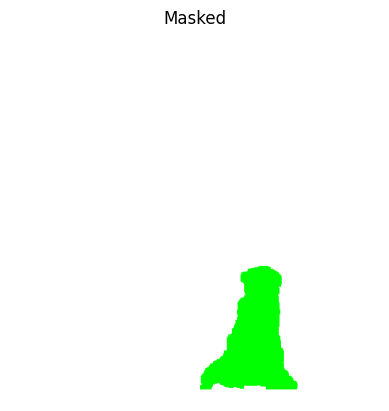

In [25]:
draw_point_cloud_2d(pcd, title='Masked')

All seems fine, so we can proceed to point cloud registration. Let us define visualization utilities:

In [26]:
def show_registration_result_3d(source, target, transform=None, rotating=False, title=''):
    source_copy = copy.deepcopy(source)
    target_copy = copy.deepcopy(target)
    source_copy.paint_uniform_color([1, 0.706, 0])
    target_copy.paint_uniform_color([0, 0.651, 0.929])
    if transform is not None:
        source_copy.transform(transform)

    if rotating:
        def rotate_view(vis):
            ctr = vis.get_view_control()
            ctr.rotate(10.0, 0.0)
            return False
    
        return o3d.visualization.draw_geometries_with_animation_callback(
            [source_copy, target_copy],
            rotate_view,
            window_name=title,
            height=480,
            width=640)
    else:
        return o3d.visualization.draw_geometries(
            [source_copy, target_copy],
            window_name=title,
            height=480,
            width=640,
            zoom=1.,
            front=[0, 1, 0],
            lookat=[0, 0, 10],
            up=[0, 0, 1])

    
def draw_registration_result_2d(
        source,
        target,
        background_image=None,
        transform=None,
        extrinsic=np.eye(4),
        title='',
        show=True,
        path_to_save=None):
    source_copy = copy.deepcopy(source)
    target_copy = copy.deepcopy(target)

    source_copy.paint_uniform_color([1, 0.706, 0])
    target_copy.paint_uniform_color([0, 0.651, 0.929])
    arrow = o3d.geometry.TriangleMesh.create_coordinate_frame(size=100, origin=source_copy.get_center())
    
    if transform is not None:
        source_copy.transform(transform)
        arrow.transform(transform)

    visualizer = o3d.visualization.Visualizer()
    visualizer.create_window(visible=False, height=480, width=640)

    visualizer.add_geometry(source_copy)
    visualizer.add_geometry(target_copy)
    visualizer.add_geometry(arrow)

    ctr = visualizer.get_view_control()
    camera_params = ctr.convert_to_pinhole_camera_parameters()
    camera_params.intrinsic = o3d.camera.PinholeCameraIntrinsic(
        height=frame.height,
        width=frame.width,
        intrinsic_matrix=frame.camera_params.intrinsic_matrix)
    camera_params.extrinsic = extrinsic
    ctr.convert_from_pinhole_camera_parameters(camera_params, allow_arbitrary=True)
    visualizer.update_renderer()
    visualizer.poll_events()

    screenshot = np.uint8(np.asarray(visualizer.capture_screen_float_buffer(True)) * 255)
    if background_image is not None:
        foreground_mask = (screenshot<255).any(2)
        screenshot[~foreground_mask] = background_image[~foreground_mask]

    if show:
        show_image(screenshot, title=title)
    if path_to_save is not None:
        save_rgb(screenshot, fpath=path_to_save)

And implement a registration pipeline (this one is actually borrowed from an official Open3D documentation):

In [27]:
registration = o3d.pipelines.registration

def preprocess_point_cloud(pcd, voxel_size):
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    pcd_fpfh = registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh


def execute_global_registration(
        source_down,
        target_down,
        source_fpfh,
        target_fpfh,
        distance_threshold):
    result = registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        registration.TransformationEstimationPointToPoint(False),
        3,
        [registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
        registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
        registration.RANSACConvergenceCriteria(100000, 0.999))
    return result


def execute_fast_global_registration(
        source_down,
        target_down,
        source_fpfh,
        target_fpfh,
        distance_threshold=0.01):
    result = registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result


def refine_registration(
        source,
        target,
        initial_transform=np.eye(4),
        distance_threshold=0.01):
    result = registration.registration_icp(
        source, target, distance_threshold, initial_transform,
        registration.TransformationEstimationPointToPlane())
    return result

In consecutive frames, the inboard is likely to have a similar orientation. So, it seems beneficial to start optimization from the transformation estimated for the previous frame, rather than optimizing from scratch. 

Accordingly, we can perform a *coarse* registration only for the first frame, and for the rest frames, only *refine* the previous transformation to match the current frame.

In [28]:
def estimate_transformation(
        pcd,
        reference_pcd,
        initial_transform=None,
        coarse=True,
        fast=False,
        voxel_size=5,
        extrinsic=np.eye(4),
        show=False):
    pcd.estimate_normals()
    reference_pcd.estimate_normals()

    aligned_pcd = copy.deepcopy(pcd)
    
    if initial_transform is None:
        initial_transform = np.eye(4)

    aligned_pcd.transform(initial_transform)

    if show:
        draw_registration_result_2d(
            aligned_pcd,
            reference_pcd,
            extrinsic=extrinsic,
            title='Unaligned')

    if fast:
        aligned_down, aligned_fpfh = preprocess_point_cloud(
            aligned_pcd, voxel_size=voxel_size)
        reference_down, reference_fpfh = preprocess_point_cloud(
            reference_pcd, voxel_size=voxel_size)
    
        distance_threshold = voxel_size * 0.1
        result = execute_fast_global_registration(
            aligned_down, reference_down,
            aligned_fpfh, reference_fpfh,
            distance_threshold=distance_threshold)
        final_transform = result.transformation
    else:
        if coarse:
            aligned_down, aligned_fpfh = preprocess_point_cloud(
                aligned_pcd, voxel_size=voxel_size)
            reference_down, reference_fpfh = preprocess_point_cloud(
                reference_pcd, voxel_size=voxel_size)

            distance_threshold = voxel_size
            result_coarse = execute_global_registration(
                aligned_down, reference_down,
                aligned_fpfh, reference_fpfh,
                distance_threshold=distance_threshold)
            coarse_transform = result_coarse.transformation
        else:
            coarse_transform = np.eye(4)

        if show:
            draw_registration_result_2d(
                aligned_pcd,
                reference_pcd,
                transform=coarse_transform,
                extrinsic=extrinsic,
                title='Pre-aligned')

        distance_threshold = voxel_size * 0.3
        result_fine = refine_registration(
            aligned_pcd,
            reference_pcd,
            initial_transform=coarse_transform,
            distance_threshold=distance_threshold)
        final_transform = result_fine.transformation

    if show:
        draw_registration_result_2d(
            aligned_pcd,
            reference_pcd,
            transform=final_transform,
            extrinsic=extrinsic,
            title='Aligned')

    final_transform = final_transform @ initial_transform
    return final_transform

Load the ground truth inboard, which will serve as a reference:

In [29]:
inboard_pcd = o3d.io.read_point_cloud(osp.join(data_root, 'inboard_3d/inboard.ply'))
inboard_pcd

PointCloud with 19640 points.

Zero-center it:

In [30]:
inboard_center = inboard_pcd.get_center()
inboard_T = np.eye(4)
inboard_T[:3, 3] = -inboard_center
inboard_pcd.transform(inboard_T)

inboard_pcd.estimate_normals()

/tmp/ipykernel_1868241/2944422999.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


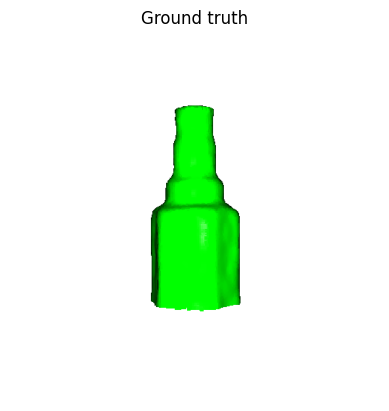

In [31]:
extrinsic = np.array([
    [1, 0, 0, 0],
    [0, 0, -1, 0],
    [0, 1, 0, 400],
    [0, 0, 0, 0]])

draw_point_cloud_2d(inboard_pcd, extrinsic=extrinsic, title='Ground truth')

Actually, we would never see the whole inboard from the above, so some orientations are infeasible. To eliminate such variants, we can keep only the upper half:

In [32]:
inboard_points = np.asarray(inboard_pcd.points)
half_mask = inboard_points[:, 1] > 0
half_inboard_pcd = o3d.geometry.PointCloud( 
    points=o3d.utility.Vector3dVector(inboard_points[half_mask]),
)
half_inboard_pcd

PointCloud with 9818 points.

In [33]:
half_inboard_center = inboard_pcd.get_center()
half_inboard_T = np.eye(4)
half_inboard_T[:3, 3] = -half_inboard_center
half_inboard_pcd.transform(half_inboard_T)

half_inboard_pcd.estimate_normals()

/tmp/ipykernel_1868241/2944422999.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


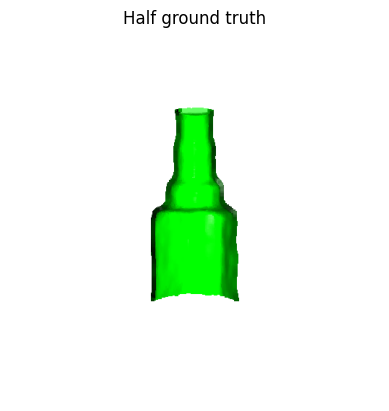

In [34]:
draw_point_cloud_2d(half_inboard_pcd, extrinsic=extrinsic, title='Half ground truth')

Now, estimate the transformation for the first frame and visualize results:

/tmp/ipykernel_1868241/2944422999.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


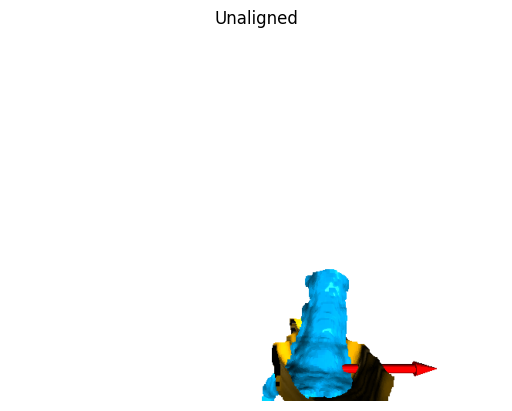

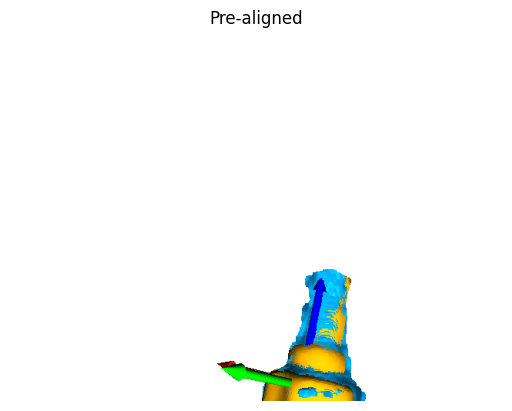

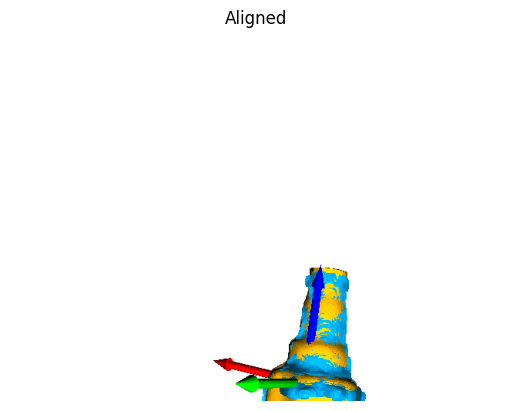

In [35]:
initial_transform = np.eye(4)
initial_transform[:3, 3] = -pcd.get_center()
initial_transform = np.linalg.inv(initial_transform)

initial_transform = estimate_transformation(
    half_inboard_pcd,
    pcd,
    initial_transform=initial_transform,
    coarse=True,
    show=True)

Bonus point: we can estimate a rotation angle from a 3D orientation! It should be more accurate, since hands would not affect pose estimation that mush, and such frames would be properly handled. 

In [44]:
def is_slanted_3d(transform, angle_threshold=np.pi/3):
    forward = transform[:3, 2]
    angle = math.atan2(forward[1], forward[0])
    angle = angle + np.pi/2
    return np.abs(angle) > angle_threshold

Save captured images, as well as *bad* and *good* frames:

In [45]:
output_dir = 'out3'
force_makedir(output_dir)

good_dir = osp.join(output_dir, 'good')
bad_dir = osp.join(output_dir, 'bad')
captured_dir = osp.join(output_dir, 'captured')
for dir in (good_dir, bad_dir):
    force_makedir(osp.join(dir, 'rgb'))
    force_makedir(osp.join(dir, 'depth'))

force_makedir(captured_dir)

transform = None
for frame in tqdm(dataset, total=len(dataset)):
    pcd = extract_inboard(frame)
    if transform is None:
        coarse = True
        transform = np.eye(4)
        transform[:3, 3] = -pcd.get_center()
        transform = np.linalg.inv(transform)
    else:
        coarse = False

    transform = estimate_transformation(
        half_inboard_pcd,
        pcd,
        initial_transform=transform,
        coarse=coarse,
        show=False)

    draw_registration_result_2d(
        half_inboard_pcd, pcd,
        background_image=frame.rgb,
        transform=transform,
        title=f'{frame.fid}',
        show=False,
        path_to_save=osp.join(captured_dir, f'aligned_{frame.fid}.png'))

    rgb_name = osp.basename(frame.rgb_fpath)
    depth_name = osp.basename(frame.depth_fpath)

    if is_slanted_3d(transform):
        shutil.copyfile(frame.rgb_fpath, osp.join(bad_dir, 'rgb', rgb_name))
        shutil.copyfile(frame.depth_fpath, osp.join(bad_dir, 'depth', depth_name))
    else:
        shutil.copyfile(frame.rgb_fpath, osp.join(good_dir, 'rgb', rgb_name))
        shutil.copyfile(frame.depth_fpath, osp.join(good_dir, 'depth', depth_name))


  0%|          | 0/473 [00:00<?, ?it/s]

Going 3D allows for more precise estimates: particularly, we could try estimating 3D poses (Task 3) from raw unmasked point clouds to find segmentation masks (Task 1). But, I intentionally tried to solve the tasks gradually, applying different techniques for both the 2D and 3D data processing. 

Still, there is room for improvements: e.g., one can refine segmented masks using 3D poses by filtering out the points that are not aligned well.